In [83]:
import os
import shutil#
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(utils)
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
import sys
del sys.modules['dataset']
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 2092, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 2092 (delta 158), reused 214 (delta 148), pack-reused 1860
Receiving objects: 100% (2092/2092), 26.57 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (761/761), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

'''
Different ways of preprocessing DataSet object



    **************************************************
    prune_outliers()
    **************************************************
        parameters: std_threshold (default: 3)

        std_threshold sets how many stds from the mean y values we will remove outliers

        # alternatives to this? running average outlier pruning? 

    **************************************************
    resample_dataset()
    **************************************************

        desc: sampling from the errors and adding to the flux value to create more data variants
        
        parameters: num_samples (default: 1)

        num_samples sets how many sets of new samples we will make from the dataset

    **************************************************
    normalize()
    **************************************************

        parameters: normalize_y (default: individual)
                    normalize_x (default: none)

        normalize_y sets how we normalize the y values, & can be
            'all'         to normalize across the dataset 
            'individual'  to normalize per example

        normalize_x sets how we normalize x values (time) & can be
            '365'         to normalize by dividing by 365
            'all'         to normalize across the dataset
            'individual'  to normalize per example

    ->set_union_x() sets instance attribute (union_x) of the dataset object union_x for the network to use in calculating 'intensity' 
    ->zero_fill(), make_masks(), are formating that the network needs
    ->error_to_sample_weight() changes the errors column to sample weights which are used in the loss function 
            i.e. MSE = (y_pred - y)**2 * sample_weights 
    
'''

dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 858
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
['/content/hetvae/data/EDELSON/NGC5548_SX.dat', '/content/hetvae/data/EDELSON/NGC5548_W1.dat', '/content/hetvae/data/EDELSON/NGC4593_W2.dat', '/content/hetvae/data/EDELSON/NGC4593_SX.dat']

/content/hetvae/src/dataset.py:173: RuntimeWarning: divide by zero encountered in true_divide


(858,)

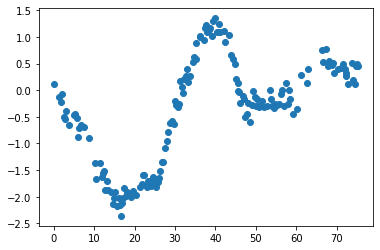

In [84]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]

# hypers: 
Edelson = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_outliers() \
            .resample_dataset(num_samples=9) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.33)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

plt.scatter(Edelson.dataset[1,:-100,0], Edelson.dataset[1,:-100,1])
Edelson.union_x.shape

In [ ]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/CAT/*/*')[:50]

Catalina = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_outliers() \
            .resample_dataset(num_samples=1) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.5)

print(
    Catalina.files, '\n',
    Catalina.union_x.shape,
    Catalina.dataset.shape,
    Catalina.subsampled_mask.shape,
    Catalina.recon_mask.shape
  )


indexes of outliers to be pruned, if any: [600 601]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [418 583]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 98 205 260 261 554 555]
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 55
created union_x attribute of length 2436
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (55, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(2436,) (55, 619, 3) (55, 619) (55, 619)


/content/hetvae/src/dataset.py:173: RuntimeWarning: divide by zero encountered in true_divide


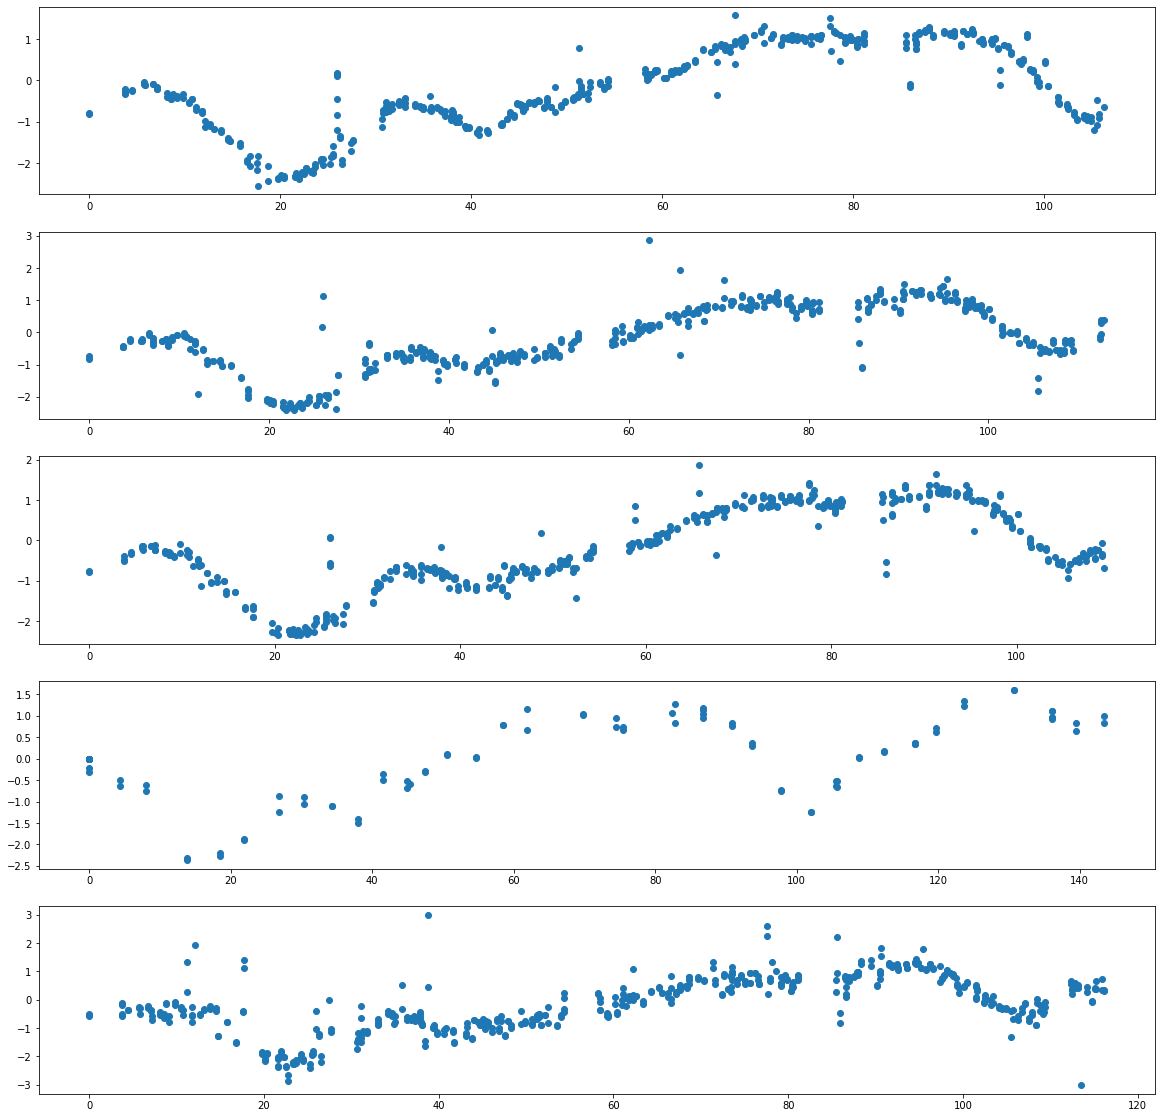

In [85]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

def get_AGN_data(file):
    agn_df = pd.read_csv(file)
    # handle formatting for new AGN
    lcs = []
    for lc_df in agn_df.groupby('Filter'):
        lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
        lcs.append(lc)

    AGN_1H2106 = DataSet()
    AGN_1H2106.dataset = lcs # skip add files part
    AGN_1H2106 = AGN_1H2106.handle_dups() \
                          .prune_outliers(std_threshold=3) \
                          .resample_dataset(num_samples=10) \
                          .normalize(normalize_y='individual', normalize_x='') \
                          .reorder() \
                          .set_union_x() \
                          .zero_fill() \
                          .error_to_sample_weight() \
                          .make_masks(frac=0.5)


        

    print(
        AGN_1H2106.union_x.shape,
        AGN_1H2106.dataset.shape,
        AGN_1H2106.subsampled_mask.shape,
        AGN_1H2106.recon_mask.shape
      )

    return AGN_1H2106
AGN_1H2106 = get_AGN_data('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')

fig,ax = plt.subplots(5,1, figsize=(20,20))
for i in range(5):
    ax[i].scatter(AGN_1H2106.dataset[i,:-130,0], AGN_1H2106.dataset[i,:-130,1])

In [86]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.3, 
                 elbo_weight=0.051, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=8.46, n=8, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.33, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=64)



In [87]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [88]:
LightCurves = np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Catalina.dataset, Catalina.subsampled_mask[:,:,np.newaxis], Catalina.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

print(LightCurves.shape)


(55, 619, 5)


In [89]:
training, valid = np.split(LightCurves, [int(np.floor(1*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [90]:
net = models.load_network(args, DIM, torch.Tensor(AGN_1H2106.union_x))
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
#net = models.load_network(args, DIM, torch.Tensor(Catalina.union_x)) 
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.002057519)

In [91]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          #train_batch[:,:,2] = torch.ones((train_batch[:,:,3].shape))
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]
          sample_weight = train_batch[:,:,2:3]
          # weights for loss in analogy to standard weighted least squares error 
  
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1)
          

    # format: compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x,
              context_y,  
              x,  # can pick the points we want to project to
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              sample_weight = sample_weight,

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )


In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.0002057519

0.002057519


In [94]:
for epoch in range(1, 101): #args.niters + 1):
    train(net, optimizer, epoch, train_loader, args)

Iter: 100, train loss: 11.7889, avg nll: 1.5442, avg kl: 2.9358, mse: 1.366479, mae: 0.206826


In [ ]:
my_utils.evaluate(net, train_loader, device=device)

tensor(-1.4900, device='cuda:0')

pred_mean: (30, 3, 619, 1) pred_std: (30, 3, 619, 1)= targets: (3, 619, 1) masks: (3, 619, 1) tps: (3, 619) inputs: (3, 619, 1)
(450, 3, 619, 1)


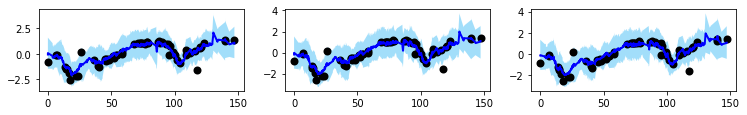

In [95]:
my_utils.viz_per_example(AGN_1H2106.dataset[0], net, device=device, k_iwae=30, fracs=[.1,0.5,.75])